In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
from matplotlib.transforms import TransformedBbox

In [2]:
HERE = os.path.dirname(os.path.abspath('__file__'))
ROOT = os.path.abspath(os.path.join(HERE, os.pardir))
DATA = os.path.join(ROOT, 'Data')

In [19]:
def annotate_clusters(clusters, dataset, ax):
    """Annotate clusters in heatmap."""
    label2obj = {
        ticklabel.get_text() : ticklabel 
        for ticklabel in ax.get_xticklabels()
    }

    for group, members in clusters.items():
        first = members[0]
        last = members[-1]
    
        bbox0 = _get_text_object_bbox(label2obj[first], ax)
        bbox1 = _get_text_object_bbox(label2obj[last], ax)

        xmin = float(first)
        xmax = float(last) + 1
        
        # Generate xrange label
        set_xrange_label(
            label=group,
            xmin=xmin,
            xmax=xmax,
            y=min(bbox0.y0, bbox1.y0),
            dataset=dataset,
            **{'fontsize':16}
        )


def set_xrange_label(label, xmin, xmax, y, dataset, *args, **kwargs):

    dx = 0.2 if dataset != 'lihc' else 0.5
    
    # 8 to give enough space for text
    dy = 12 if dataset != 'prad' else 10
    
    # Pointers angles from text
    props_1 = dict(
        connectionstyle='angle, angleA=180, angleB=90, rad=0',
        arrowstyle='-',
        lw=1,
        relpos=(0.0, 0.0),
        shrinkB=40,  #Shrink one extreme (the one closest to the heatmap)
        shrinkA=10 if dataset != 'lihc' else 2,  #Shrink the extreme close to the text so that its not touching it
    )
    
    props_2 = dict(
        connectionstyle='angle, angleA=0, angleB=90, rad=0',
        arrowstyle='-',
        lw=1,
        relpos=(0.0, 0.0),
        shrinkB=40,  #Shrink one extreme (the one closest to the heatmap)
        shrinkA=10  if dataset != 'lihc' else 2,  #Shrink the extreme close to the text so that its not touching it
    )
    
    # Middle point where the actual text goes
    x = xmin + (xmax - xmin)/2
        
    # Real annotations
    ax.annotate(
        label,
        xy=(xmin, y),
        xytext=(x - dx, y + dy),  # -0.2 to move the text to the middle
        annotation_clip=False,
        arrowprops=props_1,
        rotation=90, **kwargs,
    )
    ax.annotate(
        label,
        xy=(xmax, y),
        xytext=(x - dx, y + dy),
        annotation_clip=False,
        arrowprops=props_2,
        rotation=90, **kwargs,
    )


def _get_text_object_bbox(text_obj, ax):
    # https://stackoverflow.com/a/35419796/2912349
    transform = ax.transData.inverted()
    # the figure needs to have been drawn once, otherwise there is no renderer?
    plt.ion(); plt.show(); plt.pause(0.001)
    bb = text_obj.get_window_extent(renderer = ax.get_figure().canvas.renderer)
    # handle canvas resizing
    return TransformedBbox(bb, transform)


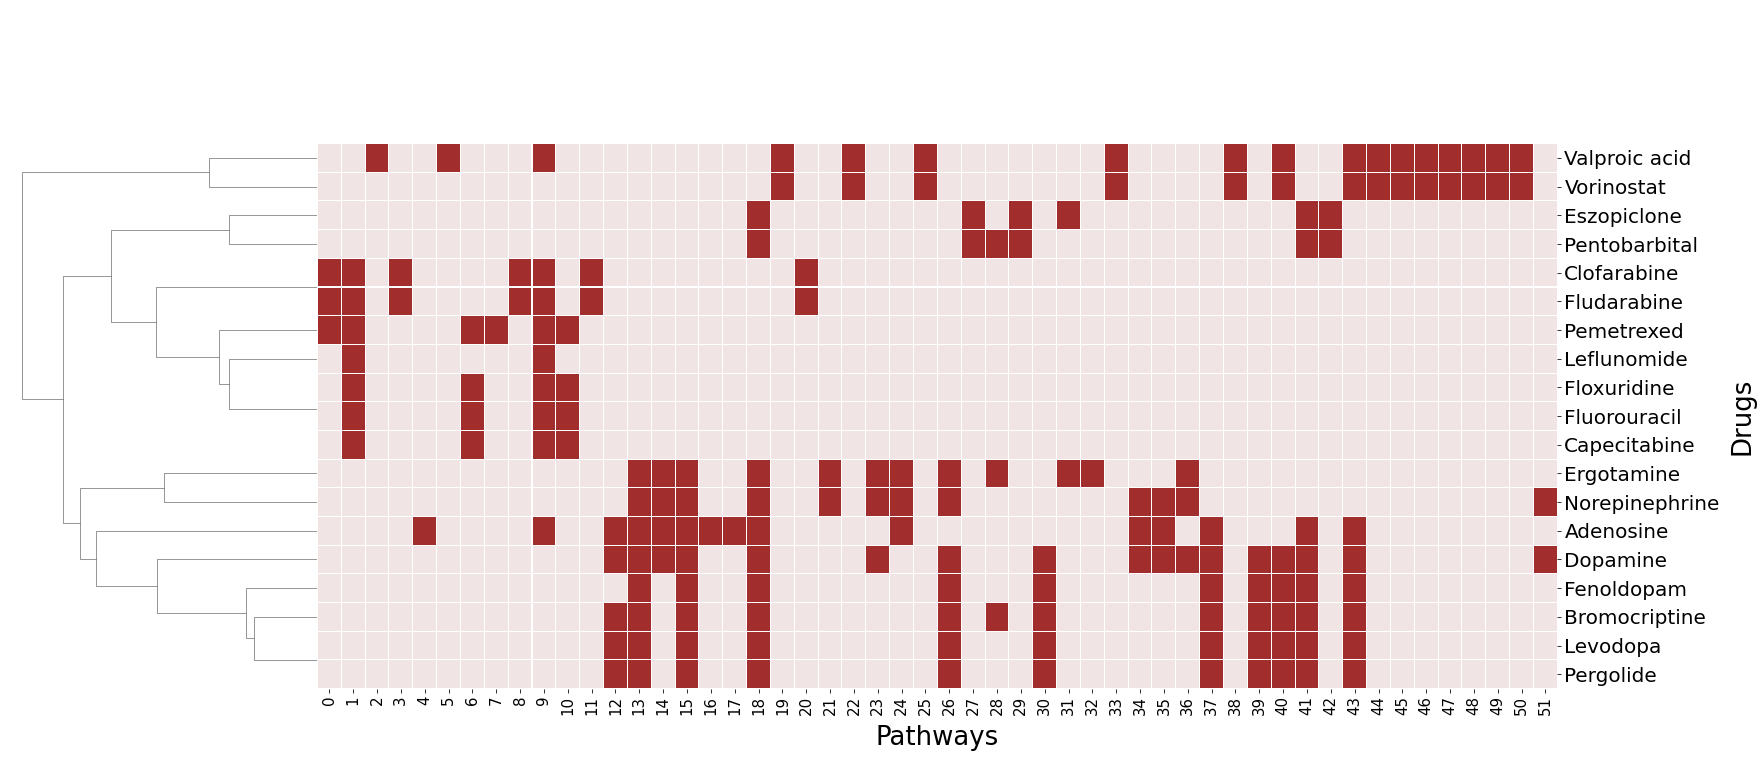

<ipython-input-22-824359a6c793>:106: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])


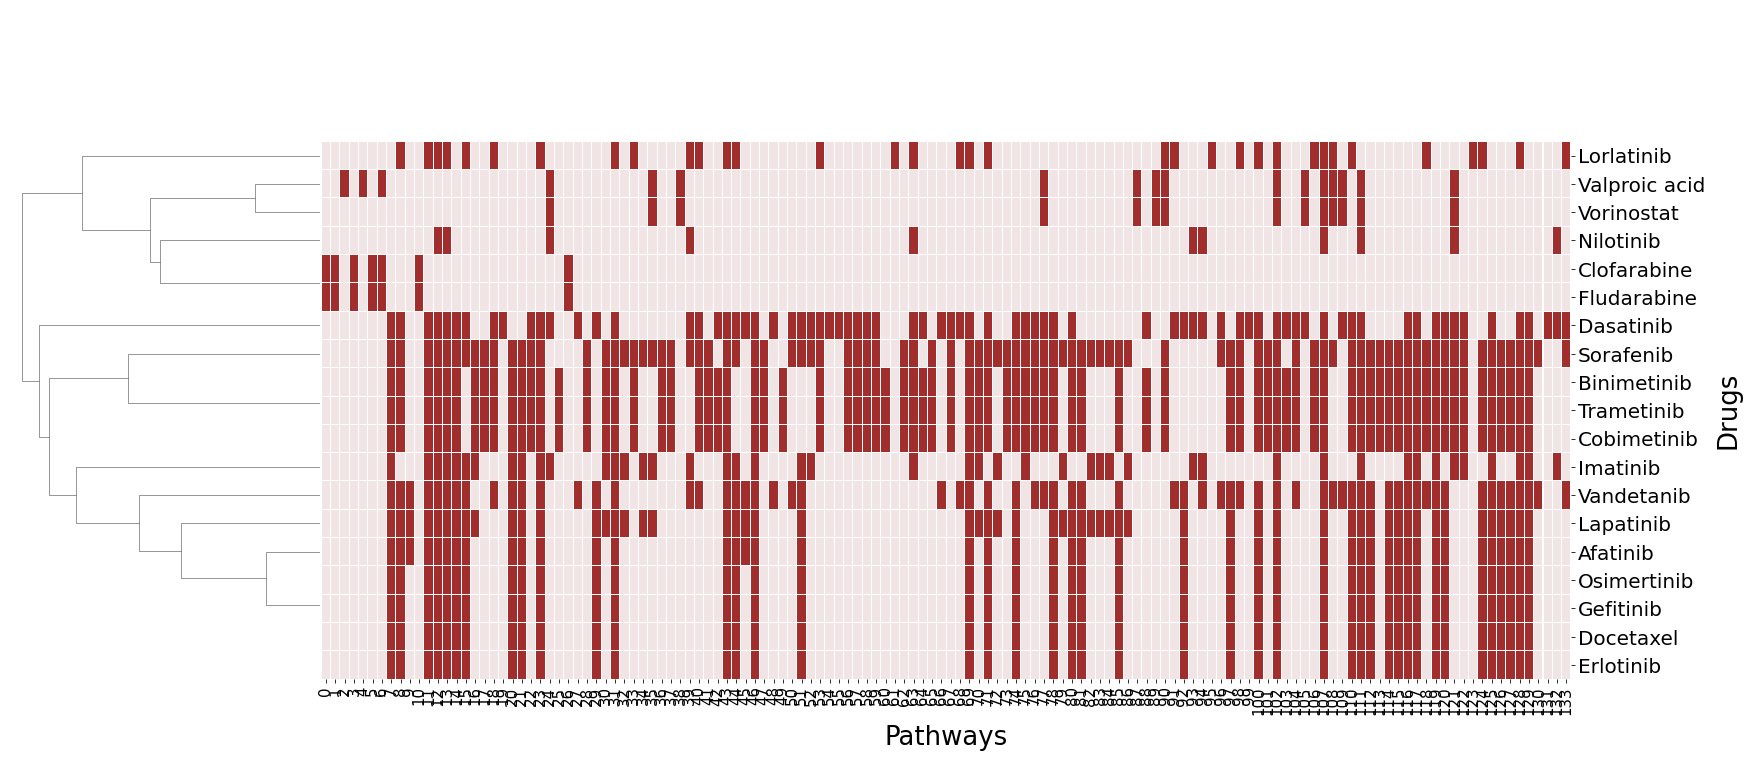

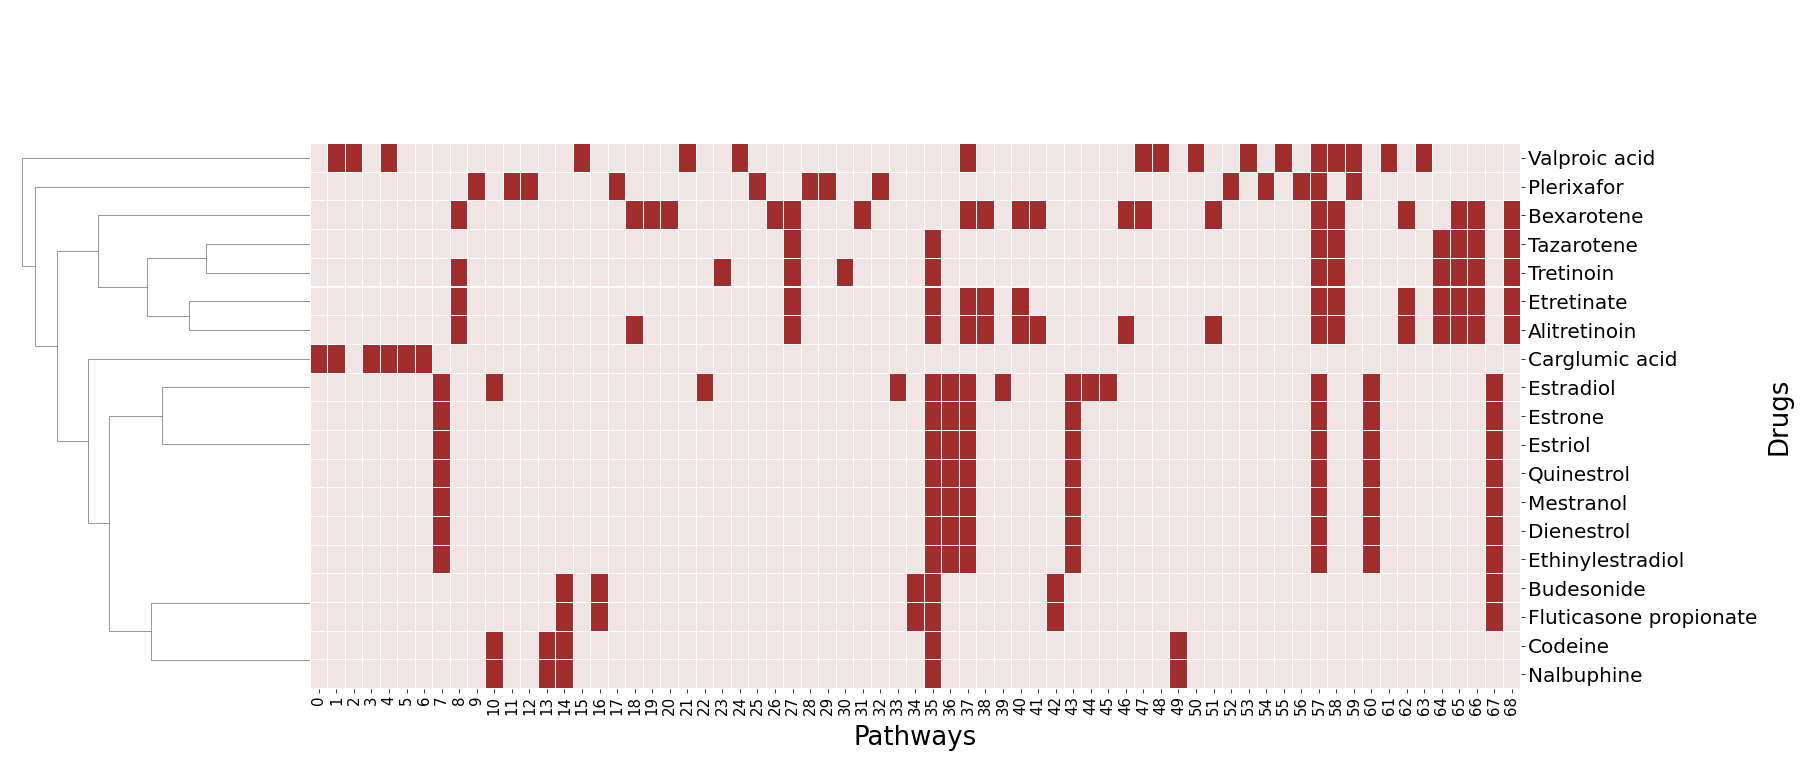

In [22]:
datasets = ['brca', 'lihc', 'prad']

name_map = {
    'brca': 'breast carcinoma', 
    'lihc': 'liver hepatocellular carcinoma',
    'prad': 'prostate adenocarcinoma',
}

# Get data to iterate over it
dfs = []

for dataset in datasets:
    df = pd.read_table(
        os.path.join(DATA, f'prioritized_drug_pathway_df_{dataset}.txt')
    ).transpose()
    df = df.loc[(df!=0).any(1)]
    dfs.append(df)
    
true_positive_drugs = [
    [0, 5, 8, 9, 10, 13], # BRCA
    [1, 7, 9], # LIHC
    [0, 4, 8], # PRAD
]

labels = ['A', 'B', 'C']

pathway_clusters = {
    'lihc': {
        'Disease pathways (1)' : ('5', '6', '7'),
        'MAPK and mTOR siganling pathways' : ('13', '14', '15'),
        'Disease pathways (2)' : ('16', '17', '18', '19'),
        'Disease pathways (3)' : ('23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39'),
        'Hormone signaling pathways' : ('40', '41', '42'),
        'Immune signaling pathways' : ('75', '76', '77', '78', '79', '80', '81'),
        'Disease pathways (4)' : ('88', '89', '90'),
        'Disease pathways (5)' : ('97', '98', '99'),
        'Metabolic pathways' : ('100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110'),
        'Disease pathways (6)' : ('111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124'),
    },
    'brca': {
        'Cell growth related pathways' : ('14', '15', '16'),
        'Disease pathways (1)' : ('18', '19', '20', '21', '22', '23', '24', '25'),
        'Neurotransmitter related pathways' : ('28', '29', '30', '31'),
        'Metabolic pathways' : ('32', '33', '34', '35', '36', '37', '38', '39', '40', '41'),
        'Disease pathways (2)' : ('46', '47', '48', '49', '50', '51'),
    },
    'prad': {
        'Hormone signaling pathways' : ('0', '1', '2', '3'),
        'Hormone and fluid secretion' : ('6', '7', '8', '9', '10', '11'),       
        'Disease pathways (1)' : ('22', '23', '24', '25'),       
        'Disease pathways (2)' : ('30', '31', '32', '33', '34', '35', '36'),       
        'Metabolic pathways' : ('37', '38', '39', '40', '41', '42'),       
        'Disease pathways (3)' : ('61', '62', '63', '64', '65', '66'),       
    },
}

# Color code
light_arr = [0.0, 0.05, 0.05, 0.05]
dark_arr = [0.0, 0.72, 0.72, 0.37]

cmap = ListedColormap(['#f1e4e4', '#a12d2d'])

for label, dataset, df, pos_drug in zip(labels, datasets, dfs, true_positive_drugs):

    ylables = df.index
    xlables = df.columns

    x_axis_labels = xlables # labels for x-axis
    y_axis_labels = ylables # labels for y-axis

    g = sns.clustermap(
        df, 
        cmap=cmap,
        fmt='g', 
        vmin=0,
        vmax=1, 
        yticklabels=y_axis_labels, 
        xticklabels=True, 
        linewidths=.01,
        linecolor='white', 
        col_cluster=False,
        figsize=(23, 10), 
        cbar_pos=None,
    )
    
    ax = g.ax_heatmap
    
    ax.set_xlabel("Pathways", {'fontsize': 26}, labelpad=10)
    ax.set_ylabel("Drugs", {'fontsize': 26}, labelpad=10)
    
    ax.tick_params(axis="x", labelsize=15, labelrotation=+90)
    ax.tick_params(axis="y", labelsize=20)
        
    # Annotate pathway clusters
    annotate_clusters(
        clusters=pathway_clusters[dataset],
        dataset=dataset,
        ax=ax,
    )
    
    # Highlight true positives
    for drug in pos_drug:
        ax.get_yticklabels()[drug].set_fontweight('bold')
        
    # Remove ticks at the end 
    ax.set_xticks([], [])
    
    ax.set_title(f'{label}) {dataset.upper()}', fontsize=60, pad=20)
        
    ax.get_figure().savefig(f'cluster_{label}.png', bbox_inches='tight', dpi=240)
